# Ch.7 Working with Keras: A deep dive

Contents : 

* **Sequential class**, **Functional API** 및 **model subclassing**을 사용하여 Keras 모델 만들기
* 기본 제공 Keras 훈련 및 평가 루프 사용
* Keras callbacks을 사용하여 훈련 customize
* 처음부터 훈련 및 평가 루프 작성하기

## A spectrum of workflows

원칙: 
* 복잡성의 점진적 공개
* 시작하기 쉬우면서도 복잡한 사용 사례를 처리할 수 있게 합니다.
* 매우 단순한 것부터 매우 유연한 것까지

## Different ways to build Keras models

* Sequential model : like a python list/stack of layers
* Functional API : graph-like model architectures
* Model subclassing : low-level and full control

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/07-01.png" width="500"><p style="text-align:center">Figure 7.1 Progressive disclosure of complexity for model building</p>

### The Sequential model

**The `Sequential` class**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

**Incrementally building a Sequential model**

In [2]:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

**Calling a model for the first time to build it**

In [3]:
model.build(input_shape=(None, 3))
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(3, 64) dtype=float32, numpy=
 array([[ 0.190227  , -0.11684732,  0.18860963, -0.17091313, -0.0561216 ,
         -0.15436623, -0.09409977,  0.00238621, -0.16032174, -0.05613616,
         -0.27299267,  0.21225649,  0.15175742, -0.26266807,  0.19756901,
         -0.06954363,  0.18576044, -0.02461585,  0.13340586, -0.14836784,
         -0.12716973, -0.24934393, -0.07982658,  0.21235037, -0.09118065,
         -0.05989638,  0.07713592,  0.14623782,  0.00215635, -0.19010308,
         -0.05205216, -0.01161236, -0.07298999,  0.01975498,  0.22246957,
         -0.24292216,  0.22604197,  0.11846933, -0.22905943, -0.0187875 ,
          0.17176715,  0.09232587,  0.1294032 ,  0.25309408, -0.10688351,
         -0.1410737 , -0.1585621 ,  0.06663349,  0.28180236,  0.23542547,
          0.29421645, -0.23397005, -0.14421678,  0.08545953,  0.16403908,
         -0.27109247, -0.2782709 , -0.28987092, -0.29184252, -0.11418857,
         -0.12067704,  0.16804111,  0.16924

**The summary method**

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


**Naming models and layers with the `name` argument**

In [5]:
model = keras.Sequential(name="my_example_model")
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))
model.build((None, 3))
model.summary()

Model: "my_example_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_first_layer (Dense)       (None, 64)                256       
_________________________________________________________________
my_last_layer (Dense)        (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


**Specifying the input shape of your model in advance**

In [6]:
model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, activation="relu"))

In [7]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                256       
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.add(layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### The Functional API

**Sequential model** : easy but limited (one input, one output)

**Functional API**:

* built the model like a graph
* can have multiple inputs/outputs
* feel like playing with LEGO bricks!


#### A simple example

**A simple Functional model with two `Dense` layers**

In [9]:
inputs = keras.Input(shape=(3,), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
inputs = keras.Input(shape=(3,), name="my_input")

In [11]:
inputs.shape

TensorShape([None, 3])

In [12]:
inputs.dtype

tf.float32

In [13]:
features = layers.Dense(64, activation="relu")(inputs)

In [14]:
features.shape

TensorShape([None, 64])

In [15]:
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_input (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


#### Multi-input, multi-output models

**A multi-input, multi-output Functional model**

고객 지원 티켓의 우선 순위를 지정하고 해당 부서로 라우팅하는 시스템 구축

**inputs**:

* 티켓 제목(텍스트 입력)
* 티켓의 텍스트 본문(텍스트 입력)
* 사용자가 추가한 모든 태그(범주 입력, 여기서는 원-핫 인코딩으로 가정)

**text inputs**: 어휘 크기의 1과 0의 배열

**outputs**:

* 티켓의 우선 순위 점수, 0과 1 사이의 스칼라(sigmoid 출력)
* 티켓을 처리해야 하는 부서(부서 집합에 대한 softmax)

In [18]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title     = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags      = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)

priority   = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(
    num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

#### Training a multi-input, multi-output model

**Training a model by providing lists of input & target arrays**

In [19]:
import numpy as np

num_samples = 1280

title_data     = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data      = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data   = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 0s 8ms/step - loss: 4.7620 - priority_loss: 0.3401 - department_loss: 4.4219 - priority_mean_absolute_error: 0.5052 - department_accuracy: 0.2453


**Training a model by providing dicts of input & target arrays**

In [20]:
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data},
          epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               {"priority": priority_data, "department": department_data})
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 8ms/step - loss: 22.7591 - priority_loss: 0.3401 - department_loss: 22.4189 - priority_mean_absolute_error: 0.5052 - department_accuracy: 0.0672


#### The power of the Functional API: Access to layer connectivity

Functional 모델은 명시적 그래프 데이터 구조입니다.

* 레이어가 어떻게 연결되어 있는지 검사
* 이전 그래프 노드 재사용

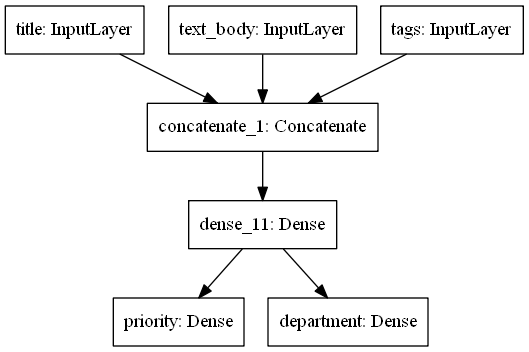

In [21]:
keras.utils.plot_model(model, "ticket_classifier.png")

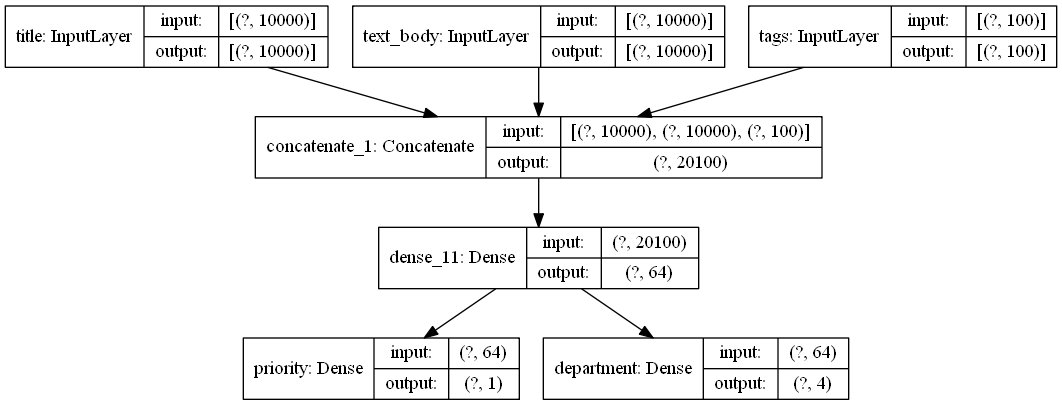

In [22]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

**Retrieving the inputs or outputs of a layer in a Functional model**

In [23]:
model.layers

In [24]:
model.layers[3].input

[<tf.Tensor 'title_1:0' shape=(None, 10000) dtype=float32>,
 <tf.Tensor 'text_body_1:0' shape=(None, 10000) dtype=float32>,
 <tf.Tensor 'tags_1:0' shape=(None, 100) dtype=float32>]

In [25]:
model.layers[3].output

<tf.Tensor 'concatenate_1/concat:0' shape=(None, 20100) dtype=float32>

**Creating a new model by reusing intermediate layer outputs**

새로운 출력: 주어진 문제 티켓이 해결하는 데 걸리는 시간 추정, 난이도 등급 (quick, medium, difficult)

In [26]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty])

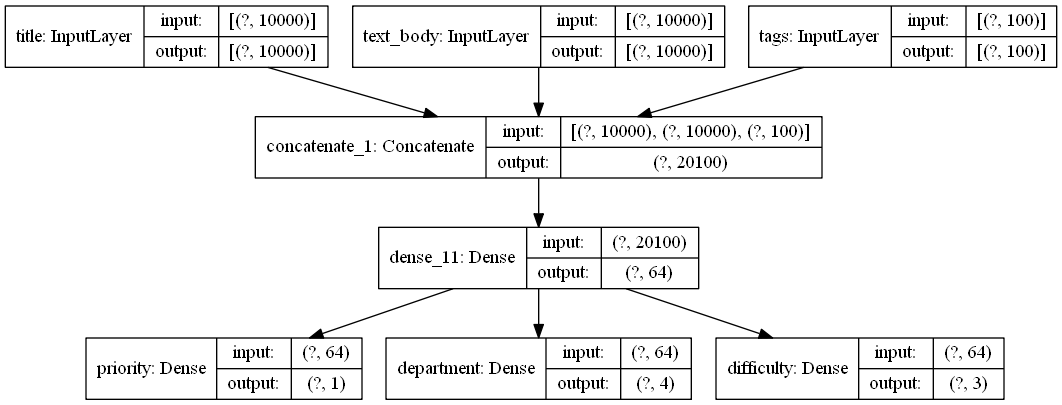

In [27]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

### Subclassing the Model class

#### Rewriting our previous example as a subclassed model

**A simple subclassed model**

In [28]:
class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(
            num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

In [29]:
model = CustomerTicketModel(num_departments=4)

priority, department = model(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

In [30]:
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit({"title": title_data,
           "text_body": text_body_data,
           "tags": tags_data},
          [priority_data, department_data],
          epochs=1)
model.evaluate({"title": title_data,
                "text_body": text_body_data,
                "tags": tags_data},
               [priority_data, department_data])
priority_preds, department_preds = model.predict({"title": title_data,
                                                  "text_body": text_body_data,
                                                  "tags": tags_data})

40/40 [==============================] - 0s 8ms/step - loss: 19.4060 - output_1_loss: 0.3401 - output_2_loss: 19.0659 - output_1_mean_absolute_error: 0.5052 - output_2_accuracy: 0.1414


#### Beware: What subclassed models don't support

Functional API 모델은 data structure 입니다. 액세스, 검사 및 수정할 수 있습니다.

Subclassed model은 bytecode 조각입니다. ```summary()``` 또는 ```plot_model()```을 사용할 수 없습니다.

### Mixing and matching different components

**Creating a Functional model that includes a subclassed model**

In [31]:
class Classifier(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"
        self.dense = layers.Dense(num_units, activation=activation)

    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

**Creating a subclassed model that includes a Functional model**

In [32]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()

### Remember: Use the right tool for the job

Functional API

* 사용 용이성과 유연성 사이에 상당한 균형을 제공합니다.
* layer 연결에 대한 직접 접근
* 가능한 경우(방향성 비순환 그래프(directed acyclic graph)) subclass 보다 더 사용

## Using built-in training and evaluation loops

**The standard workflow: `compile()`, `fit()`, `evaluate()`, `predict()`**

In [33]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 [==============================] - 16s 10ms/step - loss: 0.2960 - accuracy: 0.9115 - val_loss: 0.1483 - val_accuracy: 0.9598
Epoch 2/3
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1667 - accuracy: 0.9531 - val_loss: 0.1158 - val_accuracy: 0.9684
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.1137 - accuracy: 0.9713: 0s - loss: 0.1112 - accuracy: 0.


simple customizations:

* custom metrics
* callbacks

### Writing your own metrics

**Implementing a custom metric by subclassing the `Metric` class**

In [34]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [35]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 17s 11ms/step - loss: 0.2930 - accuracy: 0.9124 - rmse: 7.1854 - val_loss: 0.1454 - val_accuracy: 0.9578 - val_rmse: 7.3596
Epoch 2/3
1563/1563 [==============================] - 17s 11ms/step - loss: 0.1642 - accuracy: 0.9539 - rmse: 7.3571 - val_loss: 0.1234 - val_accuracy: 0.9659 - val_rmse: 7.4065
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.0980 - accuracy: 0.9743 - rmse: 7.4329


### Using callbacks

* keras.callbacks.ModelCheckpoint
* keras.callbacks.EarlyStopping
* keras.callbacks.LearningRateScheduler
* keras.callbacks.ReduceLROnPlateau
* keras.callbacks.CSVLogger

#### The EarlyStopping and ModelCheckpoint callbacks

**Using the `callbacks` argument in the `fit()` method**

In [36]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.2948 - accuracy: 0.9117 - val_loss: 0.1511 - val_accuracy: 0.9568
Epoch 2/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.1655 - accuracy: 0.9541 - val_loss: 0.1304 - val_accuracy: 0.9651
Epoch 3/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.1394 - accuracy: 0.9627 - val_loss: 0.1104 - val_accuracy: 0.9719
Epoch 4/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.1256 - accuracy: 0.9673 - val_loss: 0.1141 - val_accuracy: 0.9738
Epoch 5/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1184 - accuracy: 0.9708 - val_loss: 0.1107 - val_accuracy: 0.9738
Epoch 6/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.1119 - accuracy: 0.9739 - val_loss: 0.1063 - val_accuracy: 0.9759
Epoch 7/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1059 - accuracy: 0.9746 - val_loss: 0.1172 -

In [37]:
model = keras.models.load_model("checkpoint_path.keras")

### Writing your own callbacks

**Creating a custom callback by subclassing the `Callback` class**

In [0]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

In [0]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

### Monitoring and visualization with TensorBoard

In [0]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tensorboard = keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_log_dir",
)
model.fit(train_images, train_labels,
          epochs=10,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

In [0]:
%load_ext tensorboard
%tensorboard --logdir /full_path_to_your_log_dir

## Writing your own training and evaluation loops

1. Run the forward pass
2. Retrive the gradients
3. Update the models's weights

### Training versus inference

Attention : 
* `training` argument (e.g. Dropout)
* `tape.gradients(loss, model.trainable_wieghts)` not model.weights (e.g. `BatchNormalization`)

In [ ]:
# Not for running
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradientsn = tape.gradients(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(model.trainable_weights, gradients))

### Low-level usage of metrics

In [0]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

In [0]:
values = [0, 1, 2, 3, 4]
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f"Mean of values: {mean_tracker.result():.2f}")

### A complete training and evaluation loop

**Writing a step-by-step training loop: the training step function**

In [0]:
model = get_mnist_model()

loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = keras.metrics.Mean()

def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    return logs

**Writing a step-by-step training loop: resetting the metrics**

In [0]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

**Writing a step-by-step training loop: the loop itself**

In [0]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3
for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

**Writing a step-by-step evaluation loop**

In [0]:
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

### Make it fast with tf.function

By default: eager execution (easy for debugging)

Faster: compile with @tf.function decorator

**Adding a `tf.function` decorator to our evaluation-step function**

In [0]:
@tf.function
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

### Leveraging fit() with a custom training loop

fit( )과 처음부터 작성된 trainging 루프 사이의 중간 지점: 맞춤형 training 단계 함수를 제공하고 나머지는 프레임워크가 처리하도록 합니다.

**Implementing a custom training step to use with `fit()`**

* keras.Model의 하위 클래스로 새 클래스를 만듭니다.
* train_step(self, data) method 재정의
* metrics 속성 구현(reset_state()의 자동 호출용)

In [0]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]

In [0]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images, train_labels, epochs=3)

* one can use it with Functional API
* no need for `@tf.function` decorator

by passing metrics and loss at `compile( )` we get access to:
* `self.compiled_loss`
* `self.compiled_metrics` (allows `self.compiled_metrics.update_state()`)
* `self.metrics` (metrics + a tracker metric for loss)

In [0]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}

In [0]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

## Summary

* Keras는 *복잡성을 점진적으로 공개*한다는 원칙에 따라 다양한 워크플로를 제공합니다.
* Sequential, Functional API, subclassing the Model class
* simple:
  * `fit()` for train
  * `evaluate()` for evaluation
* more control: override `train_step()`
* evne more control: write train/evaluate loops for scratch (`@tf.function`)
